### Installation

In [1]:
%%capture
import os, re
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    import torch; v = re.match(r"[0-9\.]{3,}", str(torch.__version__)).group(0)
    xformers = "xformers==" + ("0.0.32.post2" if v == "2.8.0" else "0.0.29.post3")
    !pip install --no-deps bitsandbytes accelerate {xformers} peft trl triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets>=3.4.1,<4.0.0" "huggingface_hub>=0.34.0" hf_transfer
    !pip install --no-deps unsloth

### Unsloth

In [2]:
from unsloth import FastVisionModel # FastLanguageModel for LLMs
import torch

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/Llama-3.2-11B-Vision-Instruct-bnb-4bit", # Llama 3.2 vision support
    "unsloth/Llama-3.2-11B-Vision-bnb-4bit",
    "unsloth/Llama-3.2-90B-Vision-Instruct-bnb-4bit", # Can fit in a 80GB card!
    "unsloth/Llama-3.2-90B-Vision-bnb-4bit",

    "unsloth/Pixtral-12B-2409-bnb-4bit",              # Pixtral fits in 16GB!
    "unsloth/Pixtral-12B-Base-2409-bnb-4bit",         # Pixtral base model

    "unsloth/Qwen2-VL-2B-Instruct-bnb-4bit",          # Qwen2 VL support
    "unsloth/Qwen2-VL-7B-Instruct-bnb-4bit",
    "unsloth/Qwen2-VL-72B-Instruct-bnb-4bit",

    "unsloth/llava-v1.6-mistral-7b-hf-bnb-4bit",      # Any Llava variant works!
    "unsloth/llava-1.5-7b-hf-bnb-4bit",
] # More models at https://huggingface.co/unsloth

model, processor = FastVisionModel.from_pretrained(
    "unsloth/gemma-3-4b-pt",
    load_in_4bit = True, # Use 4bit to reduce memory use. False for 16bit LoRA.
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


2025-08-24 12:27:00.646823: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756038421.014492      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756038421.118271      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.8.9: Fast Gemma3 patching. Transformers: 4.52.4.
   \\   /|    Tesla T4. Num GPUs = 2. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: Using float16 precision for gemma3 won't work! Using float32.


model.safetensors:   0%|          | 0.00/4.38G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/210 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/70.0 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

We now add LoRA adapters for parameter efficient fine-tuning, allowing us to train only 1% of all model parameters efficiently.

**[NEW]** We also support fine-tuning only the vision component, only the language component, or both. Additionally, you can choose to fine-tune the attention modules, the MLP layers, or both!

In [3]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = True, # False if not finetuning vision layers
    finetune_language_layers   = True, # False if not finetuning language layers
    finetune_attention_modules = True, # False if not finetuning attention layers
    finetune_mlp_modules       = True, # False if not finetuning MLP layers

    r = 16,                           # The larger, the higher the accuracy, but might overfit
    lora_alpha = 16,                  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,               # We support rank stabilized LoRA
    loftq_config = None,               # And LoftQ
    target_modules = "all-linear",    # Optional now! Can specify a list if needed
    modules_to_save=[
        "lm_head",
        "embed_tokens",
    ],
)

Unsloth: Making `base_model.model.model.vision_tower.vision_model` require gradients


<a name="Data"></a>
### Data Prep
We'll use a sampled dataset of handwritten math formulas. The objective is to convert these images into a computer-readable format—specifically LaTeX—so they can be rendered. This is particularly useful for complex expressions.

You can access the dataset [here](https://huggingface.co/datasets/unsloth/LaTeX_OCR). The full dataset is [here](https://huggingface.co/datasets/linxy/LaTeX_OCR).

In [11]:
import pandas as pd
import datasets
from PIL import Image
parquet_path = "/kaggle/input/appron-prompt-dataset/dataset.parquet"  # Replace with your dataset name/path
df = pd.read_parquet(parquet_path)

# Convert to Hugging Face Dataset and cast image column (assuming 'image' is bytes)
dataset = Dataset.from_pandas(df)
dataset = dataset.cast_column("image", feature=datasets.Image(decode=True))

# Split into train and test
# dataset = dataset.train_test_split(test_size=0.1)
# train_dataset = dataset["train"]
# eval_dataset = dataset["test"]

In [ ]:
# from datasets import load_dataset
# dataset = load_dataset("unsloth/LaTeX_OCR", split = "train")

README.md:   0%|          | 0.00/519 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/344M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/38.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/68686 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7632 [00:00<?, ? examples/s]

Let's take an overview of the dataset. We'll examine the second image and its corresponding caption.

In [12]:
dataset

Dataset({
    features: ['image', 'caption'],
    num_rows: 300
})

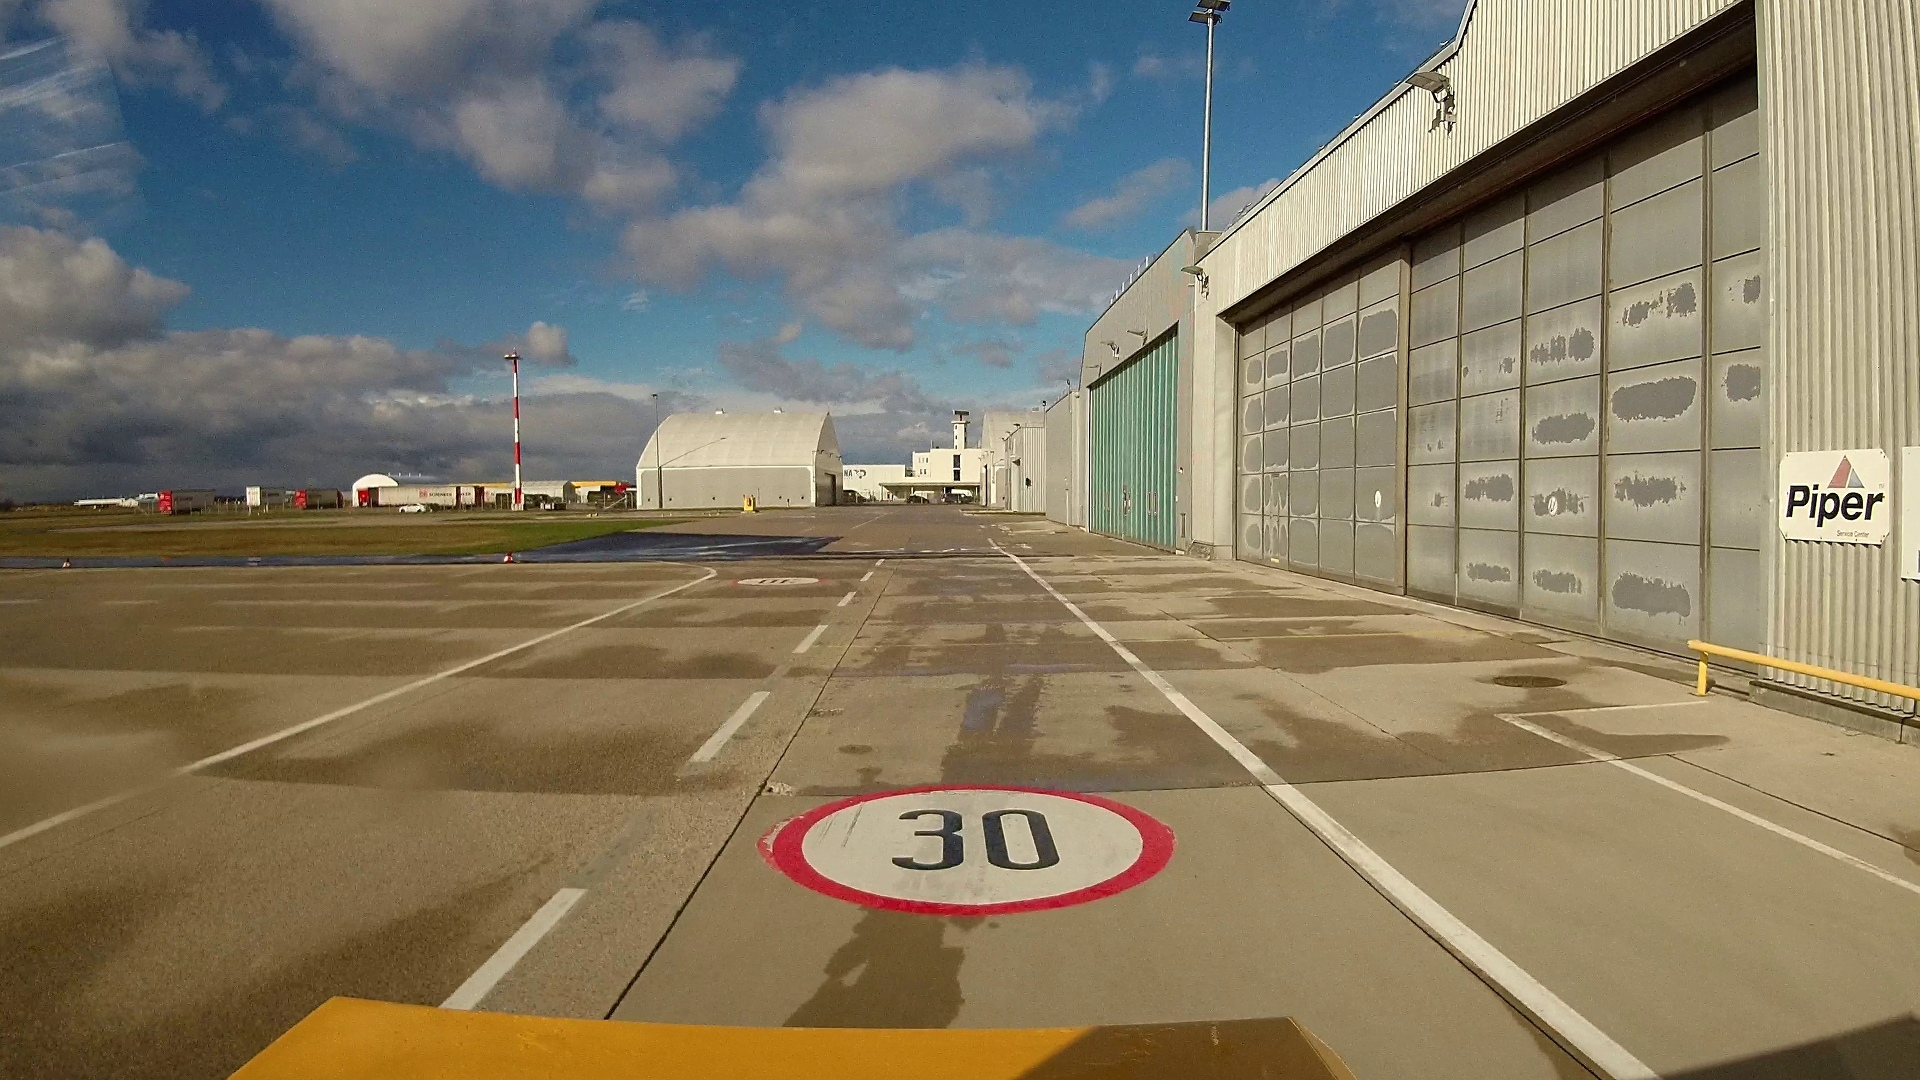

In [13]:
dataset[2]["image"]

In [15]:
dataset[2]["caption"]

'The image depicts an airport scene with clear skies and a bright blue sky scattered with clouds. The runway is visible, marked with a speed limit of 30 km/h indicated by a red circle with the number "30" in the center. The runway appears to be wet, reflecting the sunlight, suggesting recent rain or dew.\n\nIn the background, there are several hangars and buildings, including a large hangar with a white roof and green doors. The hangar on the right side of the image has a sign that reads "Piper," indicating it might be a Piper aircraft maintenance facility. There are also some smaller structures and buildings around the hangars.\n\nOn the left side of the image, there are two traffic cones placed off the runway, one closer to the foreground and another further back. These cones are likely used for marking the boundary of the runway or for safety purposes.\n\nThere are also five standard cars and one standard truck visible on the runway. The cars are positioned closer to the foreground,

To format the dataset, all vision fine-tuning tasks should follow this format:

```python
[
    {
        "role": "user",
        "content": [
            {"type": "text", "text": instruction},
            {"type": "image", "image": sample["image"]},
        ],
    },
    {
        "role": "user",
        "content": [
            {"type": "text", "text": instruction},
            {"type": "image", "image": sample["image"]},
        ],
    },
]
```

In [20]:
instruction = "Describe accurately what you see in this image."

def convert_to_conversation(sample):
    conversation = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": instruction},
                {"type": "image", "image": sample["image"]},
            ],
        },
        {"role": "assistant", "content": [{"type": "text", "text": sample["caption"]}]},
    ]
    return {"messages": conversation}
pass

Let's convert the dataset into the "correct" format for finetuning:

In [21]:
converted_dataset = [convert_to_conversation(sample) for sample in dataset]

The first example is now structured like below:

In [22]:
converted_dataset[0]

{'messages': [{'role': 'user',
   'content': [{'type': 'text',
     'text': 'Describe accurately what you see in this image.'},
    {'type': 'image',
     'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1920x1080>}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': 'The image depicts an airport scene with a clear blue sky scattered with white clouds. The runway is wet, reflecting the sunlight, indicating recent rain or ongoing maintenance. The runway is marked with white lines for navigation and safety. There are several vehicles on the runway, including:\n\n- 9 Standard Cars (2 in the left far, 6 in the center far, 1 in the right far)\n- 1 Taxiing Vehicle (1 in the right far)\n- 1 Passenger Jet (1 in the center far)\n- 2 Business Jets (2 in the left far)\n\nThe airport has a large hangar structure to the right, which appears to be a hangar for aircraft storage. The hangar has a grayish exterior with windows and doors. There are also other buildings a

Lets take the Gemma 3 instruction chat template and use it in our base model

In [23]:
from unsloth import get_chat_template

processor = get_chat_template(
    processor,
    "gemma-3"
)

Before fine-tuning, let us evaluate the base model's performance. We do not expect strong results, as it has not encountered this chat template before.

In [24]:
FastVisionModel.for_inference(model)  # Enable for inference!

image = dataset[2]["image"]
instruction = "Describe accurately what you see in this image."

messages = [
    {
        "role": "user",
        "content": [{"type": "image"}, {"type": "text", "text": instruction}],
    }
]
input_text = processor.apply_chat_template(messages, add_generation_prompt=True)
inputs = processor(
    image,
    input_text,
    add_special_tokens=False,
    return_tensors="pt",
).to("cuda")

from transformers import TextStreamer

text_streamer = TextStreamer(processor, skip_prompt=True)
result = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                        use_cache=True, temperature = 1.0, top_p = 0.95, top_k = 64)

ഒരു
<start_of_image>
ഒരു


ഒരു
ഒരു
<start_of_image>
ഒരു
ഒരു
ഒരു
ഒരു
ഒരു
ഒരു
ഒരു
ഒരു
ഒരു
ഒരു
ഒരു
ഒരു
ഒരു
ഒരു
ഒരു
ഒരു
ഒരു
ഒരു
ഒരു
ഒരു
ഒരു
ഒരു
ഒരു
ഒരു
ഒരു
ഒരു
ഒരു
ഒരു
ഒരു
ഒരു
ഒരു
ഒരു
ഒരു
ഒരു
ഒരു
ഒരു
ഒരു
ഒരു
ഒരു
ഒരു
ഒരു
ഒരു
ഒരു
ഒരു
ഒരു
ഒരു
ഒരു
ഒരു
ഒരു
ഒരു
ഒരു
ഒരു
ഒരു
ഒരു
ഒരു
ഒരു
ഒരു
ഒരു



You can see it's absolutely terrible! It doesn't follow instructions at all

<a name="Train"></a>
### Train the model
Now let's train our model. We do 60 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and turn off `max_steps=None`. We also support TRL's `DPOTrainer`!

We use our new `UnslothVisionDataCollator` which will help in our vision finetuning setup.

In [25]:
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

FastVisionModel.for_training(model) # Enable for training!

trainer = SFTTrainer(
    model=model,
    train_dataset=converted_dataset,
    processing_class=processor.tokenizer,
    data_collator=UnslothVisionDataCollator(model, processor),
    args = SFTConfig(
        per_device_train_batch_size = 1,
        gradient_accumulation_steps = 4,
        gradient_checkpointing = True,

        # use reentrant checkpointing
        gradient_checkpointing_kwargs = {"use_reentrant": False},
        max_grad_norm = 0.3,              # max gradient norm based on QLoRA paper
        warmup_ratio = 0.03,
        max_steps = 30,
        #num_train_epochs = 2,          # Set this instead of max_steps for full training runs
        learning_rate = 2e-4,
        logging_steps = 1,
        save_strategy="steps",
        optim = "adamw_torch_fused",
        weight_decay = 0.01,
        lr_scheduler_type = "cosine",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none",             # For Weights and Biases

        # You MUST put the below items for vision finetuning:
        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        max_length = 2048,
    )
)

Unsloth: Switching to float32 training since model cannot work with float16


In [26]:
# @title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.741 GB.
5.416 GB of memory reserved.


In [27]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 300 | Num Epochs = 1 | Total steps = 30
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 38,497,792 of 4,338,577,264 (0.89% trained)


In [28]:
# @title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(
    f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training."
)
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

811.8206 seconds used for training.
13.53 minutes used for training.
Peak reserved memory = 7.131 GB.
Peak reserved memory for training = 1.715 GB.
Peak reserved memory % of max memory = 48.375 %.
Peak reserved memory for training % of max memory = 11.634 %.


<a name="Inference"></a>
### Inference
Let's run the model! You can modify the instruction and input—just leave the output blank.

We'll use the best hyperparameters for inference on Gemma: `top_p=0.95`, `top_k=64`, and `temperature=1.0`.

In [34]:
FastVisionModel.for_inference(model)  # Enable for inference!

image = dataset[10]["image"]
instruction = "Describe accurately what you see in this image."

messages = [
    {
        "role": "user",
        "content": [{"type": "image"}, {"type": "text", "text": instruction}],
    }
]

input_text = processor.apply_chat_template(messages, add_generation_prompt=True)
inputs = processor(
    image,
    input_text,
    add_special_tokens=False,
    return_tensors="pt",
).to("cuda")

from transformers import TextStreamer

text_streamer = TextStreamer(processor, skip_prompt=True)
result = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                        use_cache=True, temperature = 1.0, top_p = 0.95, top_k = 64)

<bos><start_of_turn>user


<start_of_image><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><im

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 2.12 MiB is free. Process 2324 has 14.74 GiB memory in use. Of the allocated memory 14.55 GiB is allocated by PyTorch, and 26.61 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

<a name="Save"></a>
### Saving, loading finetuned models
To save the final model as LoRA adapters, use Hugging Face’s `push_to_hub` for online saving, or `save_pretrained` for local storage.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model. To save to 16bit or GGUF, scroll down!

In [30]:
model.save_pretrained("lora_model")  # Local saving
processor.save_pretrained("lora_model")
# model.push_to_hub("your_name/lora_model", token = "...") # Online saving
# processor.push_to_hub("your_name/lora_model", token = "...") # Online saving

['lora_model/processor_config.json']

Now if you want to load the LoRA adapters we just saved for inference, set `False` to `True`:

In [33]:
if True:
    from unsloth import FastVisionModel

    model, processor = FastVisionModel.from_pretrained(
        model_name="lora_model",  # YOUR MODEL YOU USED FOR TRAINING
        load_in_4bit=True,  # Set to False for 16bit LoRA
    )
    FastVisionModel.for_inference(model)  # Enable for inference!

FastVisionModel.for_inference(model)  # Enable for inference!

sample = dataset[1]
image = sample["image"].convert("RGB")
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "text",
                "text": sample["caption"],
            },
            {
                "type": "image",
            },
        ],
    },
]
input_text = processor.apply_chat_template(messages, add_generation_prompt=True)
inputs = processor(
    image,
    input_text,
    add_special_tokens=False,
    return_tensors="pt",
).to("cuda")

from transformers import TextStreamer

text_streamer = TextStreamer(processor.tokenizer, skip_prompt=True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 256,
                   use_cache=True, temperature = 1.0, top_p = 0.95, top_k = 64)

==((====))==  Unsloth 2025.8.9: Fast Gemma3 patching. Transformers: 4.52.4.
   \\   /|    Tesla T4. Num GPUs = 2. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: Using float16 precision for gemma3 won't work! Using float32.


OutOfMemoryError: CUDA out of memory. Tried to allocate 50.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 2.12 MiB is free. Process 2324 has 14.74 GiB memory in use. Of the allocated memory 14.53 GiB is allocated by PyTorch, and 46.33 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

### Saving to float16 for VLLM

We also support saving to `float16` directly. Select `merged_16bit` for float16. Use `push_to_hub_merged` to upload to your Hugging Face account! You can go to https://huggingface.co/settings/tokens for your personal tokens.

In [ ]:
# Select ONLY 1 to save! (Both not needed!)

# Save locally to 16bit
if False: model.save_pretrained_merged("unsloth_finetune", processor,)

# To export and save to your Hugging Face account
if False: model.push_to_hub_merged("YOUR_USERNAME/unsloth_finetune", processor, token = "PUT_HERE")

And we're done! If you have any questions on Unsloth, we have a [Discord](https://discord.gg/unsloth) channel! If you find any bugs or want to keep updated with the latest LLM stuff, or need help, join projects etc, feel free to join our Discord!

Some other links:
1. Train your own reasoning model - Llama GRPO notebook [Free Colab](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3.1_(8B)-GRPO.ipynb)
2. Saving finetunes to Ollama. [Free notebook](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3_(8B)-Ollama.ipynb)
3. Llama 3.2 Vision finetuning - Radiography use case. [Free Colab](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3.2_(11B)-Vision.ipynb)
6. See notebooks for DPO, ORPO, Continued pretraining, conversational finetuning and more on our [documentation](https://docs.unsloth.ai/get-started/unsloth-notebooks)!

<div class="align-center">
  <a href="https://unsloth.ai"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
  <a href="https://discord.gg/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord.png" width="145"></a>
  <a href="https://docs.unsloth.ai/"><img src="https://github.com/unslothai/unsloth/blob/main/images/documentation%20green%20button.png?raw=true" width="125"></a>

  Join Discord if you need help + ⭐️ <i>Star us on <a href="https://github.com/unslothai/unsloth">Github</a> </i> ⭐️
</div>
